## Setup

In [ ]:
import matplotlib.pyplot as plt
import uniformised_space_utils as usu
import pickle
import plots
import numpy as np
import interpolation
from collections import defaultdict
from scipy.stats import circmean, binned_statistic_2d
import forward_models_causal_inference
from custom_causal_inference import CustomCausalInference
import utils
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
gam_data_path = './base_bayesian_contour_1_circular_gam.pkl'

In [20]:
with open(gam_data_path, 'rb') as f:
    Peter_gam_data = pickle.load(f)
r_n_key = 'r_n'
len(Peter_gam_data[r_n_key]), len(Peter_gam_data['s_n']), Peter_gam_data.keys()

(24219,
 24219,
 dict_keys(['r_n', 'pred_pairs', 'reg_dict', 'x_n', 'y_n', 'alpha', 'V_0', 'eta_0', 'Lambda_0', 'beta_0', 'V_n', 'eta_n', 'Lambda_n', 'beta_n', 'Y', 'Mean_error_covariance', 'Covariance_matrix', 'beta_0_contour', 'r_squ', 'posterior_contours', 'ranges', 'coef_inds', 'reg_list', 'full_X', 'full_pred', 'non_x_pred', 'pdf_mat', 'full_pdf_mat', 'full_vec_mat', 's_impacts', 'residual_variance', 'r_n_full_cleaned', 's_n']))

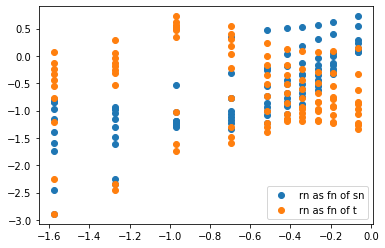

In [36]:
inds = np.array([62, 74,  86,  97, 104, 108, 111, 114, 117, 122])
stims = np.linspace(-np.pi, np.pi, 250)
gam_rn = []
for ind_t in inds:
    for ind_sn in inds:
        gam_rn.append(Peter_gam_data['full_pdf_mat'][ind_t, ind_sn, 3])
gam_t, gam_s_n = np.meshgrid(stims[inds],
                             stims[inds],
                             indexing='ij')
plt.scatter(gam_s_n, gam_rn, label = 'rn as fn of sn')
plt.scatter(gam_t, gam_rn, label = 'rn as fn of t')
plt.legend()
plt.show()

In [5]:
Peter_gam_data['reg_dict']['m_n'].shape, Peter_gam_data['reg_dict'].keys()

((24219,),
 dict_keys(['a_n', 'd_n', 'm_n', 'r_n', 'r_n_1', 'r_n_2', 'r_n_3', 'r_n_4', 's_b_n', 's_n', 's_n_1', 's_n_2', 's_n_3', 's_n_4', 't_n']))

In [17]:
with open('./uniform_model_base_inv_kappa_free.pkl', 'rb') as f:
    Peter_u_map = pickle.load(f)
Peter_u_map.keys()

dict_keys(['samples', 'responses', 'sim_responses', 'seed', 'lr', 'log_u_sigma', 'pdf_centers', 'pdf_log_weights', 'pdf_log_widths', 'sim_hist', 'pdf', 'grid', 'losses'])

## Data vis and filtering

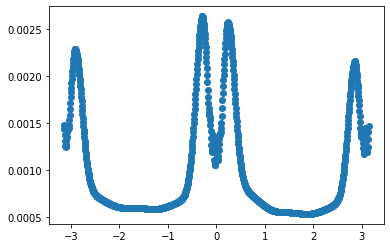

In [7]:
plt.plot(Peter_u_map['grid'], Peter_u_map['pdf'], 'o', label='Peter uniform model')

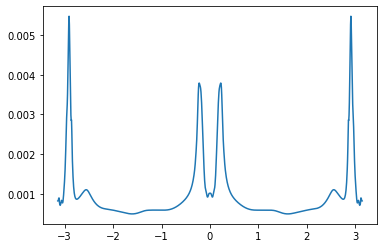

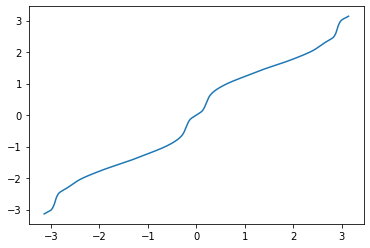

In [21]:
with open("uniform_base_flexible_means_120_final_fits.pkl", "rb") as f:
    uniform_base_flexible_means_120_final_fits = pickle.load(f)
umap_flex_means = usu.UnifMap(data=uniform_base_flexible_means_120_final_fits, pdf_key='mean_pdf')
umap_flex_means.get_cdf_and_inverse_cdf()
uniform_angles = np.linspace(-np.pi, np.pi, uniform_base_flexible_means_120_final_fits["mean_pdf"].shape[0])
plt.plot(uniform_angles, uniform_base_flexible_means_120_final_fits["mean_pdf"])
plt.show()
plt.plot(uniform_angles, umap_flex_means.angle_space_to_unif_space(uniform_angles))
plt.show()

### Filter lapses

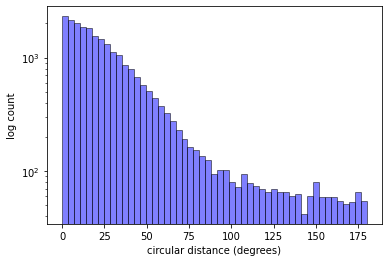

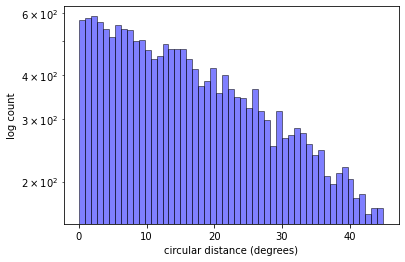

In [8]:
# plot circular distance between s_n and r_n
plt.hist(np.rad2deg(utils.circular_dist(Peter_gam_data['s_n'], Peter_gam_data['r_n'])), bins=51, 
         density=False, alpha=0.5, label='circular distance between s_n and r_n', 
         log=True, color='blue', edgecolor='black')
plt.xlabel('circular distance (degrees)')
plt.ylabel('log count')
plt.show()
filtered_gam_data = utils.get_filtered_gam(Peter_gam_data, max_circ_dist=np.pi/4)
plt.hist(np.rad2deg(utils.circular_dist(filtered_gam_data['reg_dict']['s_n'], filtered_gam_data['reg_dict']['r_n'])), bins=51, 
         density=False, alpha=0.5, label='circular distance between s_n and r_n', 
         log=True, color='blue', edgecolor='black')
plt.xlabel('circular distance (degrees)')
plt.ylabel('log count')
plt.show()

In [10]:
gam_data = filtered_gam_data
r_n_key = 'r_n'

In [11]:
# For Peter_gam_data, 'r_n' and 'r_n_1' are shifted by 1. This is not true for filtered_gam_data as not all initial r_n values are present
filtered_gam_data['reg_dict']['r_n'][:5], filtered_gam_data['reg_dict']['r_n_1'][:5], Peter_gam_data['reg_dict']['r_n'][:15], Peter_gam_data['reg_dict']['r_n_1'][:15]

(array([-0.9577744 , -1.9254405 ,  1.5152643 , -0.73781514, -1.0586948 ],
       dtype=float32),
 array([ 0.4641688 , -0.88817334, -0.95516825,  1.5152643 ,  1.9868486 ],
       dtype=float32),
 array([-0.9577744 , -0.88817334, -1.9254405 ,  0.6985433 , -1.5115154 ,
         2.800031  , -0.95516825,  1.5152643 , -0.73781514, -1.5950444 ,
         1.7693756 ,  1.9868486 , -1.0586948 ,  1.5500758 , -1.6374042 ],
       dtype=float32),
 array([ 0.4641688 , -0.9577744 , -0.88817334, -1.9254405 ,  0.6985433 ,
        -1.5115154 ,  2.800031  , -0.95516825,  1.5152643 , -0.73781514,
        -1.5950444 ,  1.7693756 ,  1.9868486 , -1.0586948 ,  1.5500758 ],
       dtype=float32))

### Serial dependence plots

In [19]:
# Create dataset with s_n, s_n_1, r_n, r_n_1
serial_dep_data = np.zeros((len(gam_data['reg_dict']['s_n'])-1, 5))
for index in range(len(gam_data['reg_dict']['s_n'])-1):
    serial_dep_data[index, :] = np.array([gam_data['reg_dict']['s_n'][index+1], gam_data['reg_dict']['s_n'][index], gam_data['reg_dict'][r_n_key][index+1], gam_data['reg_dict'][r_n_key][index], index+1])

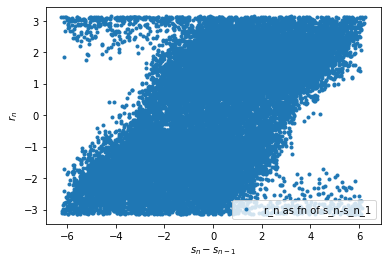

In [20]:
order_sn = np.argsort(serial_dep_data[:, 0])  # sort by the first column
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 1], serial_dep_data[order_sn, 2], '.', label='r_n as fn of s_n-s_n_1')
plt.xlabel('$s_n-s_{n-1}$')
plt.ylabel('$r_n$')
plt.legend()
plt.show()

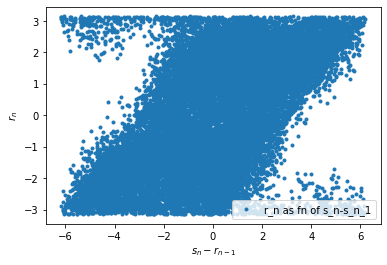

In [21]:
order_sn = np.argsort(serial_dep_data[:, 0])  # sort by the first column
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 3], serial_dep_data[order_sn, 2], '.', label='r_n as fn of s_n-s_n_1')
plt.xlabel('$s_n-r_{n-1}$')
plt.ylabel('$r_n$')
plt.legend()
plt.show()

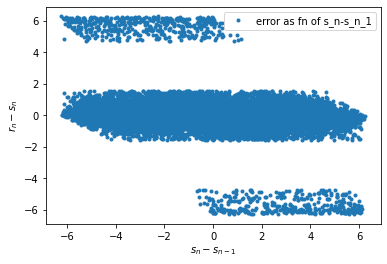

In [22]:
plt.plot(serial_dep_data[order_sn, 0] - serial_dep_data[order_sn, 1], serial_dep_data[order_sn, 2] - serial_dep_data[order_sn, 0], '.', label='error as fn of s_n-s_n_1')
plt.xlabel('$s_n-s_{n-1}$')
plt.ylabel('$r_n-s_n$')
plt.legend()
plt.show()

### Mean response over grid from filtered data

In [37]:
Peter_gam_data["full_pdf_mat"].shape

(250, 250, 7)

In [ ]:
reg_keys = ['r_n_1', 's_n_1', 's_b_n', 'm_n', 'r_n_2', 'r_n_3', 'r_n_4']
binning = 41
gam_data['full_pdf_mat'] = np.zeros((binning, binning, len(reg_keys)))

Fraction of H where value is nan for r_n_1: 0.0005668934240362812


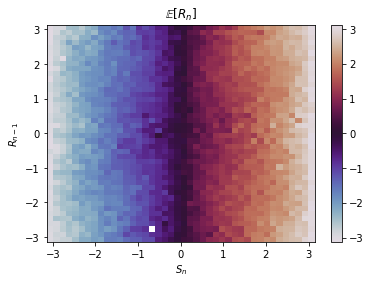

Fraction of H where value is nan for s_n_1: 0.0


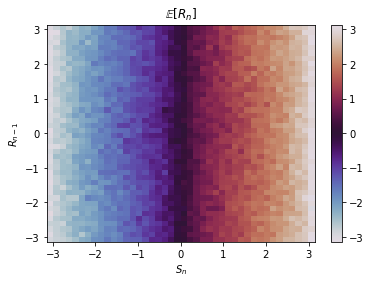

Fraction of H where value is nan for s_b_n: 0.0


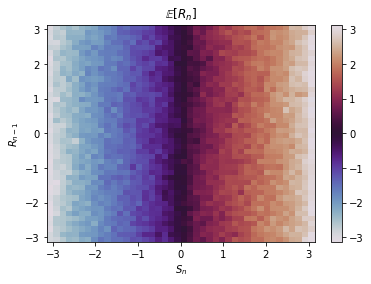

Fraction of H where value is nan for m_n: 0.0


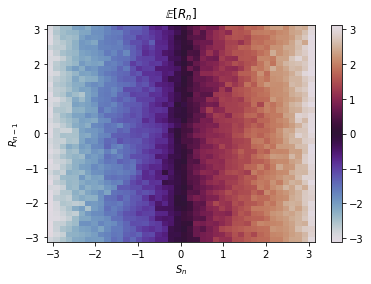

Fraction of H where value is nan for r_n_2: 0.0


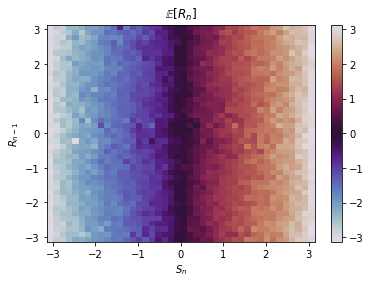

Fraction of H where value is nan for r_n_3: 0.0


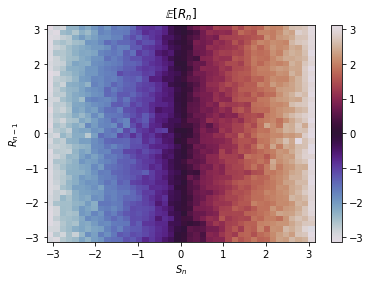

Fraction of H where value is nan for r_n_4: 0.0


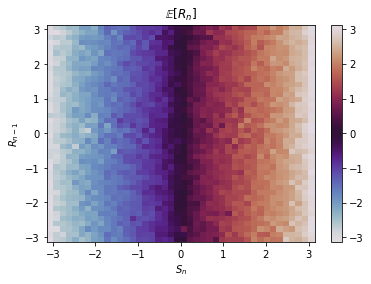

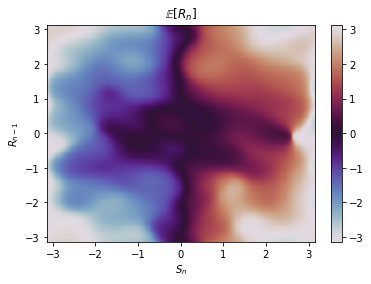

In [ ]:
# TODO: For matching Peter's binsize, the histogram has 70% nan values; Fill missing values using linear interp,
# Gaussian smooting or circular-distance transforms (i.e. nearest non-nan cell). For now, use coarse binning.
circmean_mpi_pi = lambda x: circmean(x, high=np.pi, low=-np.pi)
for reg_idx, reg_key in enumerate(reg_keys):
       H, xedges, yedges, binnumber = binned_statistic_2d(y=gam_data['reg_dict'][reg_key], 
                                                          x=gam_data['reg_dict']['s_n'], 
                                                        values=gam_data['reg_dict']['r_n'], 
                                                 statistic=circmean_mpi_pi, bins=binning, expand_binnumbers=True)
       XX, YY = np.meshgrid(xedges, yedges)
       gam_data['full_pdf_mat'][:, :, reg_idx] = H.T
       print(f'Fraction of H where value is nan for {reg_key}: {np.sum(np.isnan(H)) / H.size}')

       plt.pcolormesh(XX,YY,H.T,cmap='twilight')#,vmin=-0.4,vmax=0.4)
       plt.colorbar()
       plt.xlabel('$S_{n}$')
       plt.ylabel('$R_{n-1}$')
       plt.title('$\mathbb{E}[R_{n}]$')
       plt.show()
       assert np.allclose(xedges, yedges, atol=np.deg2rad(.1)), f"{xedges}, {yedges}"
       assert np.allclose(xedges, np.linspace(-np.pi, np.pi, num=len(xedges)), atol=np.deg2rad(.1))

_, xedges_250, yedges_250, _ = binned_statistic_2d(y=gam_data['reg_dict']['r_n'][:-1], x=gam_data['reg_dict']['s_n'][1:], 
                                                   values=gam_data['reg_dict']['r_n'][1:], 
                                            statistic=circmean_mpi_pi, bins=250, expand_binnumbers=True)
plt.pcolormesh(*np.meshgrid(xedges_250, yedges_250),Peter_gam_data['full_pdf_mat'][:, :, 0],cmap='twilight')
plt.colorbar()
plt.xlabel('$S_{n}$')
plt.ylabel('$R_{n-1}$')
plt.title('$\mathbb{E}[R_{n}]$')
plt.show()

## Using the mean response as internal space map

In [26]:
def sn_to_mean_rn_map(s_ns, r_ns, sn_grid=None):
    if sn_grid is None:
        sn_grid = np.linspace(-np.pi, np.pi, 1000)
    responses = defaultdict(list)
    for sn, rn in zip(s_ns, r_ns):
        index_in_grid = int(interpolation.find_closest_mu_bs(mu=sn, mus=sn_grid))
        responses[index_in_grid].append(rn)
    mean_responses = np.array([circmean(high=np.pi, low=-np.pi, samples=responses[i]) for i in range(len(sn_grid))])
    return sn_grid, mean_responses

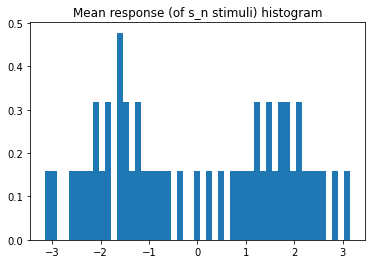

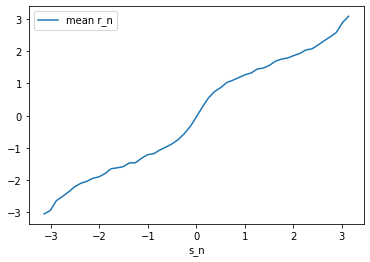

In [27]:
# sn_grid, mean_r_n = sn_to_mean_rn_map(serial_dep_data[:, 0], serial_dep_data[:, 2], sn_grid=Peter_u_map['grid'])
sn_grid, mean_r_n = sn_to_mean_rn_map(serial_dep_data[:, 0], serial_dep_data[:, 2], sn_grid=np.linspace(-np.pi, np.pi, 51))   
bin_counts, _, _ = plt.hist(mean_r_n, bins=np.linspace(-np.pi, np.pi, len(sn_grid)+1), density=True)
plt.title('Mean response (of s_n stimuli) histogram')
plt.show()
# handle wrap
plt.plot(sn_grid, mean_r_n, label='mean r_n')
plt.xlabel('s_n')
plt.legend()
plt.show()
unif_fn_dict = {'grid': sn_grid, 'pdf': bin_counts, 'angle_to_u': mean_r_n}
with open('./unif_mean_response_map.pkl', 'wb') as f:
    pickle.dump(unif_fn_dict, f)

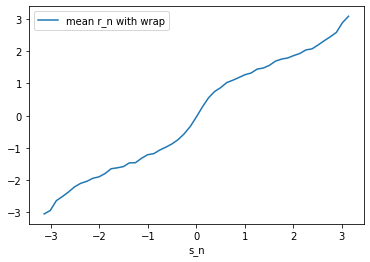

In [28]:
mean_r_n_wrap = np.array(mean_r_n)
for idx, (sn, mrn) in enumerate(zip(sn_grid, mean_r_n)):
    if abs(sn - mrn) > np.pi:
        print(idx, sn, mrn)
        mean_r_n_wrap[idx] = np.min(mean_r_n_wrap[idx:idx+7])
    if (idx > 0) and (mean_r_n_wrap[idx] < mean_r_n_wrap[idx-1]):
        print(f'not monotonic: {idx, mean_r_n_wrap[idx], mean_r_n_wrap[idx-1], sn}')
plt.plot(sn_grid, mean_r_n_wrap, label='mean r_n with wrap')
plt.xlabel('s_n')
plt.legend()
plt.show()
unif_fn_dict = {'grid': sn_grid, 'f': mean_r_n_wrap, 'f_inv': mean_r_n}
with open('./unif_mean_response_map.pkl', 'wb') as f:
    pickle.dump(unif_fn_dict, f)

In [15]:
with open('./filtered_data_gam.pkl', 'wb') as f:
    pickle.dump(gam_data, f)

In [29]:
stimuli_grid = np.linspace(-np.pi, np.pi, 250)
t_index = 0  # use r_n_1 as regressor
causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
        model=CustomCausalInference(decision_rule='mean'),
        angle_gam_data_path=gam_data_path,
        unif_fn_data_path='./mean_response_map.pkl',)
mean_response_map = causal_inference_estimator.unif_map

In [30]:
def get_repulsion_mat(sns, ts, rns):
    repulsion = np.zeros_like(sns)
    for idx, (t, s_n, r_n) in enumerate(zip(ts, sns, rns)):
        us_n = mean_response_map.angle_space_to_unif_space(s_n)
        ut = mean_response_map.angle_space_to_unif_space(t)
        ur_n = mean_response_map.angle_space_to_unif_space(r_n)
        if utils.circular_dist(us_n, ut) < utils.circular_dist(ut, ur_n) + utils.circular_dist(us_n, ur_n):
            repulsion[idx] = utils.circular_dist(ut, ur_n) + utils.circular_dist(us_n, ur_n) - utils.circular_dist(us_n, ut)
    return repulsion

In [30]:
def plot_heatmap_uspace(data, usns, uts, grid_dim, title):
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(usns.reshape((grid_dim, grid_dim)), uts.reshape((grid_dim, grid_dim)), 
            data, shading='auto', cmap='twilight')
    plt.colorbar(label='circular distance to r_n(t, s_n)')
    plt.xlabel('us_n')
    plt.ylabel('ut')
    plt.title(title)
    plt.show()

Comparing with fits

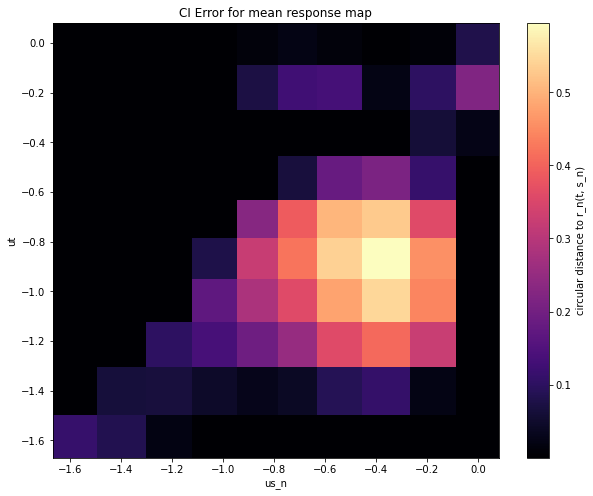

In [32]:
grid_sz = 100
optimal_kappa_pairs_filepath = f'./learned_data/optimal_kappa_pairs_{grid_sz}_t{t_index}.pkl'
min_error_for_idx_pc_filepath = f'./learned_data/min_error_for_idx_pc_{grid_sz}_t{t_index}.pkl'
min_error_for_idx_filepath = f'./learned_data/min_error_for_idx_{grid_sz}_t{t_index}.pkl'
s_ns_filepath = f'./learned_data/selected_s_n_{grid_sz}_t{t_index}.npy'
ts_filepath = f'./learned_data/selected_t_{grid_sz}_t{t_index}.npy'
r_ns_filepath = f'./learned_data/selected_r_n_{grid_sz}_t{t_index}.npy'
with open(optimal_kappa_pairs_filepath, 'rb') as f:
    optimal_kappa_pairs = pickle.load(f)
with open(min_error_for_idx_pc_filepath, 'rb') as f:
    min_error_for_idx_pc = pickle.load(f)
with open(min_error_for_idx_filepath, 'rb') as f:
    min_error_for_idx = pickle.load(f)
s_ns = np.load(s_ns_filepath)
ts = np.load(ts_filepath)
r_ns = np.load(r_ns_filepath)
grid_dim = int(np.sqrt(s_ns.shape[0]))
err_mat = np.zeros_like(s_ns).reshape((grid_dim, grid_dim))
for i in range(grid_dim):
    for j in range(grid_dim):
        err_mat[i, j] = min_error_for_idx['sn'][i*grid_dim+j]
plot_heatmap_uspace(err_mat, mean_response_map.angle_space_to_unif_space(s_ns), 
                    mean_response_map.angle_space_to_unif_space(ts),
                    grid_dim, title='CI Error for mean response map')

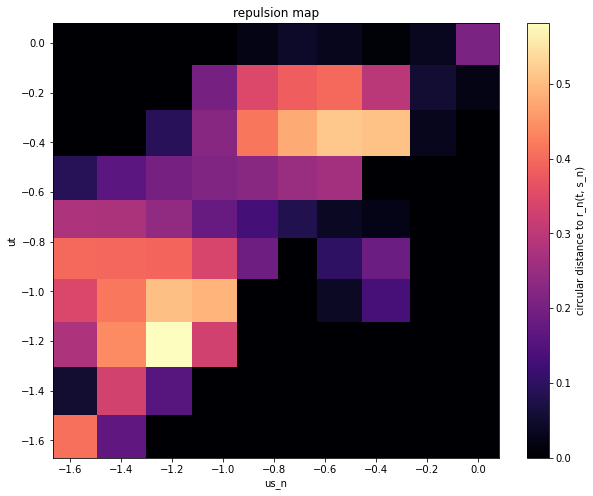

In [33]:
repulsion = get_repulsion_mat(s_ns, ts, r_ns).reshape((grid_dim, grid_dim))
plot_heatmap_uspace(repulsion, mean_response_map.angle_space_to_unif_space(s_ns), 
                    mean_response_map.angle_space_to_unif_space(ts),
                    grid_dim, title='repulsion map')

In [ ]:
with open('./raw_data_gam.pkl', 'rb') as f:
    loaded_gam_data = pickle.load(f)
loaded_gam_data["full_pdf_mat"]

### Raw data results analysis

In [26]:
grid_sz = 100
grid_dim = 10
reflect = True
t_index = 0  # use r_n_1 as regressor

Results for , 
13 0.2764728071953009 0.15840128879371118 -39.759036144578324 -73.01204819277109 -77.75986
14 0.2564396922670027 0.12455700002263415 -29.638554216867465 -73.01204819277109 -75.71752
15 0.21237077709955354 0.05301233070533762 -23.855421686746997 -73.01204819277109 -71.69252
42 0.27338018495051 0.250053165563898 -55.66265060240964 -29.638554216867465 -7.194607
43 0.21331145061961365 0.20310359828534974 -39.759036144578324 -29.638554216867465 -9.91264
52 0.2806949360096196 0.2595647955104141 -55.66265060240964 -23.855421686746997 -1.6912777
53 0.1967278555032319 0.17630291407647514 -39.759036144578324 -23.855421686746997 -6.1653247
62 0.26600509911165604 0.24409140743509639 -55.66265060240964 -19.518072289156635 0.963043
72 0.23121264030014244 0.20460058555589233 -55.66265060240964 -15.18072289156627 2.1437914


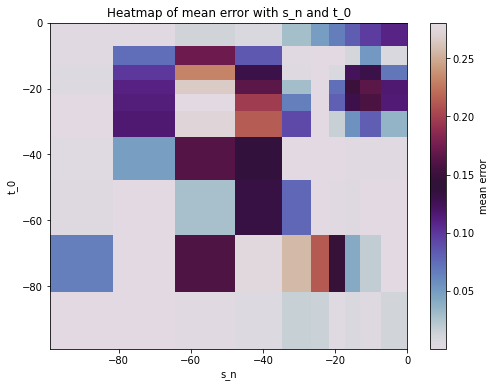

Results for , _filtered
45 0.33882420670825564 0.44129195906735097 21.951219512195145 -21.95121951219512 47.772605668917286
81 0.2009795445450191 0.2556757315698195 -136.09756097560975 136.09756097560975 -118.52127603541847


<Figure size 432x288 with 0 Axes>

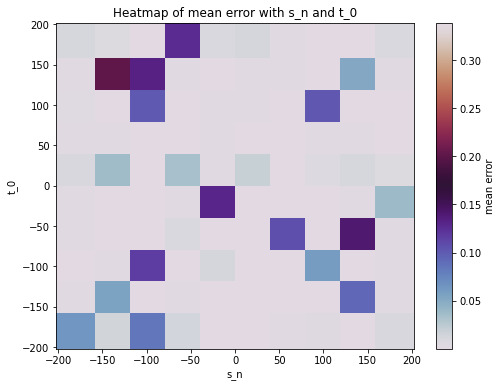

Results for _fl_means, 
File ./learned_data/optimal_kappa_pairs_100_t0_True_fl_means.pkl not found
Results for _fl_means, _filtered
27 0.30571201129892245 0.30383719726350744 100.97560975609758 -100.97560975609755 105.03422740596038
36 0.29338507811991565 0.28424885357323326 57.07317073170734 -57.07317073170729 68.99461813717221
38 0.3216757354877524 0.4153402766444616 136.09756097560975 -57.07317073170729 143.3802344631109
45 0.38597006491711605 0.3768755722872652 21.951219512195145 -21.95121951219512 47.772605668917286


<Figure size 432x288 with 0 Axes>

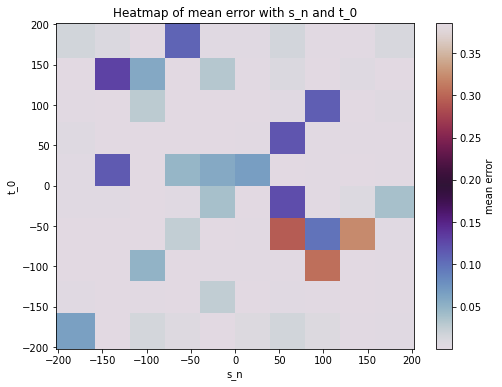

<Figure size 432x288 with 0 Axes>

In [ ]:
# '' means Peter's umap, '_fl_means' is uniform_base_flexible_means_120_final_fits
# '' means GAM data, '_filtered'refers to filtered raw data on top of which a 42x42 histogram is created to get r_n(sn, t)
for unif_pref in ['', '_fl_means']:
    for data_type_pref in ['', '_filtered']:
        print(f'Results for {unif_pref}, {data_type_pref}')
        try:
            with open(f'./learned_data/optimal_kappa_pairs_{grid_sz}_t{t_index}_{reflect}{unif_pref}{data_type_pref}.pkl', 'rb') as f:
                optimal_kappa_pairs = pickle.load(f)
        except FileNotFoundError:
            print(f'File ./learned_data/optimal_kappa_pairs_{grid_sz}_t{t_index}_{reflect}{unif_pref}{data_type_pref}.pkl not found')
            continue
        s_ns = np.rad2deg(np.load(f'./learned_data/selected_s_n_{grid_sz}_t{t_index}_{reflect}{unif_pref}{data_type_pref}.npy'))
        ts = np.rad2deg(np.load(f'./learned_data/selected_t_{grid_sz}_t{t_index}_{reflect}{unif_pref}{data_type_pref}.npy'))
        r_ns = np.rad2deg(np.load(f'./learned_data/selected_r_n_{grid_sz}_t{t_index}_{reflect}{unif_pref}{data_type_pref}.npy'))
        with open(f'./learned_data/min_error_for_idx_{grid_sz}_t{t_index}_{reflect}{unif_pref}{data_type_pref}.pkl', 'rb') as f:
            min_error_for_idx = pickle.load(f)
        min_err = np.zeros_like(s_ns)
        for idx in min_error_for_idx['sn']:
            min_err[int(idx)] = min_error_for_idx['sn'][idx]
            if min_error_for_idx['sn'][idx] > np.deg2rad(10):
                print(idx, min_error_for_idx['sn'][idx], min_error_for_idx['t'][idx], s_ns[idx], ts[idx], r_ns[idx])
        min_err = min_err.reshape((grid_dim, grid_dim))
        plots.heatmap_f_s_n_t(f_s_n_t=min_err, s_n=s_ns.reshape((grid_dim, grid_dim)), 
                              t=ts.reshape((grid_dim, grid_dim)), 
                              f_name='mean error', xlabel='s_n', 
                              ylabel=f't_{t_index}', image_path=None)

For raw data filtered for max_dist = np.pi/4:
45 0.3346800611030796 0.44147220656569974 21.951219512195145 -21.95121951219512 47.772605668917286

81 0.19474167509260054 0.259112833812813 -136.09756097560975 136.09756097560975 -118.52127603541847

For more 5 deg err:
18 0.0951550807248216 0.013687010333147676 136.09756097560975 -136.09756097560975 122.99768297970186

22 0.10966691320103106 0.10922723099852405 -100.97560975609755 -100.97560975609755 -92.66497338512073

36 0.10923681117071915 0.20975810480666723 57.07317073170734 -57.07317073170729 68.99461813717221

38 0.14179864126070552 0.23593522073454043 136.09756097560975 -57.07317073170729 143.3802344631109

44 0.13306385750614025 0.12421407715494048 -21.95121951219512 -21.95121951219512 -34.6349553664512

45 0.3346800611030796 0.44147220656569974 21.951219512195145 -21.95121951219512 47.772605668917286

72 0.10012617222656406 0.14114118723506852 -100.97560975609755 100.97560975609758 -93.54093148579652

77 0.0982814960575098 0.09713746663407807 100.97560975609758 100.97560975609758 93.84158275268214

81 0.19474167509260054 0.259112833812813 -136.09756097560975 136.09756097560975 -118.52127603541847

82 0.13079730474392637 0.2108194581422982 -100.97560975609755 136.09756097560975 -91.7596386408247

93 0.12741914129381282 0.25241993607412594 -57.07317073170729 180.0 -49.95971420342541
